Preconditioning
===

We call $C$ a preconditioner to the matrix $A$ if 
* $C^{-1} A \approx I$
* the matrix-vector multiplication $w = C^{-1} r$ is cheap

One extreme case is $C = A$, where the first claim is optimally satisfied, but (in general) not the second. The opposite extreme is $C = I$. 

If $A$ is an SPD matrix, we like to have an SPD preconditioner $C$. In this case, the quality of the approximation can be measured by the spectral bounds

$$
0 < \gamma_1 \leq \frac{x^T A x }{x^T C x} \leq \gamma_2 \qquad \forall \, 0 \neq x \in {\mathbb R^n}
$$

The Rayleigh quotient is bounded by $\gamma_1$ and $\gamma_2$ from below and from above.
These spectral bounds are bounds for the eigenvalues $\lambda$ of the generalized eigenvalue problem

$$
A x = \lambda C x
$$

If $\lambda_i$ is an eigenvalue with eigenvector $x_i$, then $x_i^T A x_i = \lambda_i x_i^T C x_i$, and thus $\lambda_i \in [\gamma_1, \gamma_2]$

The preconditioned Richardson iteration
---
We use the preconditioner to obtain the correction from the residuum:

$$
\qquad  x^{k+1} = x^k - \alpha C^{-1} (b - A x^k)
$$

The error is now propagated as

$$
e^{k+1} = M e^k = (I - \alpha C^{-1} A) e^k
$$

If we could use the ideal preconditioner $C = A$, and set $\alpha = 1$, then $M = 0$, and we converge in one iteration.


The error-propagation matrix $M$ is self-adjoint in the energy inner product
\begin{eqnarray*}
\left< M x, y \right>_A & = & (A M x)^T y \\
& = & \left\{ A (x - \alpha C^{-1} A x) \right\}^T y  \\
& = & x^T (A - \alpha A C^{-1} A) y \\
& = & \left< x, M y \right>_A
\end{eqnarray*}

as well as in the inner products

$$
\left< x, y \right>_C \qquad \text{and} \qquad \left< x, y \right>_{AC^{-1} A}.
$$

The error is monotonically decreased in the corresponding norms. In particular the last one is practically interesting since it is computationally available:

\begin{eqnarray*}
\| x - x^\ast \|_{AC^{-1} A}^2 & = & \| A (x - x^\ast) \|_{C^{-1}}^2 \\
& = & \| A x - b \|_{C^{-1}}^2
\end{eqnarray*}

With the residuum $r$ and preconditioned residuum $w$, i.e.

$$
r = b - A x \qquad \text{and} \qquad w = C^{-1} r
$$

the error becomes

$$
\| x - x^\ast \|_{AC^{-1}A}^2 = r^T w
$$

In [2]:
from ngsolve import *
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
fes = H1(mesh, order=1)
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx+10*u*v*dx).Assemble()
f = LinearForm(x*y*v*dx).Assemble()
gfu = GridFunction(fes)

A very simple preconditioner is the Jacobi-preconditioner

$$
C = \text{diag} A
$$ 

If $A$ is SPD, then all diagonal entries are positive, and $C$ is SPD as well.

In NGSolve, we can obtain a Jacobi preconditioner as follows. The result is a linear operator providing the linear operation

$$
w := C^{-1} * r
$$

In [3]:
pre = a.mat.CreateSmoother()

In [4]:
hv = gfu.vec.CreateVector()
hv2 = gfu.vec.CreateVector()
hv3 = gfu.vec.CreateVector()
hv.SetRandom()
hv.data /= Norm(hv)
for k in range(20):
    hv2.data = a.mat * hv
    hv3.data = pre * hv2
    rho = Norm(hv3)
    print (rho)
    hv.data = 1/rho * hv3

0.5628463859901822
1.3004844587339313
1.3642450612653387
1.4017278282832693
1.428927912054942
1.4511979272962623
1.4709697187344926
1.489456390475471
1.5072557909082451
1.5246072026789994
1.5415208146951107
1.557860994429892
1.5734139487420604
1.5879473334387257
1.601258905051369
1.6132090247120108
1.6237346368041081
1.632846787976177
1.6406169867162068
1.6471585575973842


In [5]:
alpha = 1 / rho
r = f.vec.CreateVector()
w = f.vec.CreateVector()
gfu.vec[:] = 0

w.data = pre * f.vec
err0 = sqrt(InnerProduct(f.vec, w))
its = 0
errhist = []
while True:
    r.data = f.vec - a.mat * gfu.vec
    w.data = pre * r
    err = sqrt(InnerProduct(r,w))
    # print ("iteration", its, "res=", err)
    errhist.append (err)
    gfu.vec.data += alpha * w
    if err < 1e-8 * err0 or its > 10000: break
    its = its+1
print ("needed", its, "iterations")

needed 1234 iterations


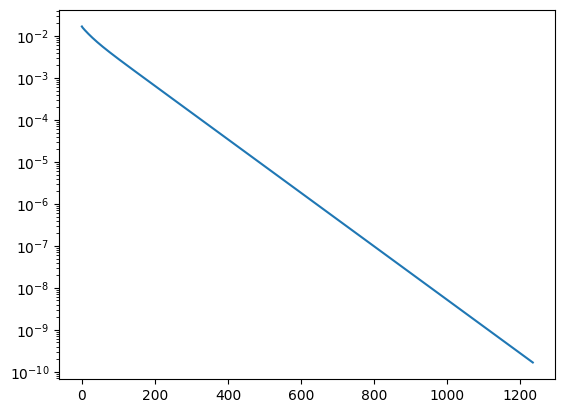

In [8]:
import matplotlib.pyplot as plt
plt.yscale('log')
plt.plot (errhist);

By situation is not considerably improved by the diagonal preconditioner. However, if we have a bilinear-form with variable coefficient, or large coefficients in the Robin - boundary condition such as

$$
A(u,v) = \int_\Omega \nabla u \nabla v \, dx + 10^8 \int_{\Gamma_R} u v \, ds,
$$

the Jacobi preconditioner captures these parameters (experiment in  excercise, theory soon).

The preconditioned gradient method
---

To introduce the preconditioner into the gradient method we proceed as follows. Since $C$ is SPD, we are allowed to form its square-root

$$
C^{1/2}
$$

as well as its inverse. The linear system $A x = b$ is equivalent to 

$$
C^{-1/2} A C^{-1/2} \; C^{1/2} x = C^{-1/2} b.
$$

With the definition of transformed quantities 

$$
\tilde A = C^{-1/2} A C^{-1/2}, \qquad
\tilde b = C^{-1/2} b, \qquad
\tilde x = C^{1/2} x
$$

we have the linear system

$$
\tilde A \tilde x = \tilde b
$$

The transformed matrix $\tilde A$ is SPD as well.

We apply the gradient method for the transformed system:

Given $\tilde x^0$ <br>
$\tilde r^0 = \tilde b - \tilde A \tilde x^0$ <br>
for $k = 0, 1, 2, \ldots$ <br>
$\qquad \tilde p = \tilde A \tilde r^k$ <br>
$\qquad \alpha = \frac{{\tilde r^k}^T \tilde r^k }{ {\tilde r^k}^T \tilde p}$ <br>
$\qquad \tilde x^{k+1} = \tilde x^k + \alpha \tilde r^k$ <br>
$\qquad \tilde r^{k+1} = \tilde r^k - \alpha \tilde p$ <br>


The error analysis of the gradient method provides

$$
\| \tilde x^\ast - \tilde x^{k+1} \|_{\tilde A} \leq \rho
\| \tilde x^\ast - \tilde x^{k} \|_{\tilde A},
$$

and substituting back

$$
\| x^\ast -  x^{k+1} \|_A \leq \rho \|  x^\ast -  x^{k} \|_A
$$

Since we cannot compute with the transformed system 
we transform back via

$$
\tilde x^k = C^{1/2} x^k, \qquad \tilde r^k = C^{-1/2} r, 
\qquad \tilde p = C^{-1/2} p
$$

and obtain

Given $x^0$ <br>
$C^{-1/2} r^0 = C^{-1/2} b  - C^{-1/2} A C^{-1/2} C^{1/2} x^0$ <br>
for $k = 0, 1, 2, \ldots$ <br>
$\qquad C^{-1/2} p = C^{-1/2} A C^{-1/2} C^{-1/2} r^k$ <br>
$\qquad \alpha = \frac{\{C^{-1/2} r^k \}^T C^{-1/2} r^k \, }{ \, \{ C^{-1/2} r^k\}^T C^{-1/2} p}$ <br>
$\qquad C^{1/2} x^{k+1} = C^{1/2} x^k + \alpha C^{-1/2} r^k$ <br>
$\qquad C^{-1/2} r^{k+1} = C^{-1/2} r^k - \alpha C^{-1/2} p$ <br>

now we simplify, and introduce $w = C^{-1} r$

Given $x^0$ <br>
$r^0 = b - A x^0$ <br>
for $k = 0, 1, 2, \ldots$ <br>
$\qquad w = C^{-1} r^k$ <br>
$\qquad p = A w$ <br>
$\qquad \alpha = \frac{w^T r^k}{w^T p^k}$ <br>
$\qquad x^{k+1} = x^k + \alpha w$ <br>
$\qquad r^{k+1} = r^k - \alpha p$ <br>

In [13]:
r = f.vec.CreateVector()
w = f.vec.CreateVector()
p = f.vec.CreateVector()

gfu.vec[:] = 0
r.data = f.vec
w.data = pre*r
err0 = sqrt(InnerProduct(r,w))
its = 0
errhist = []
while True:
    w.data = pre*r
    p.data = a.mat * w
    err2 = InnerProduct(w,r)
    alpha = err2 / InnerProduct(w,p)

    # print ("iteration", its, "res=", sqrt(err2))
    errhist.append (sqrt(err2))
    gfu.vec.data += alpha * w
    r.data -= alpha * p
    if sqrt(err2) < 1e-8 * err0 or its > 10000: break
    its = its+1
print ("needed", its, "iterations")

needed 602 iterations


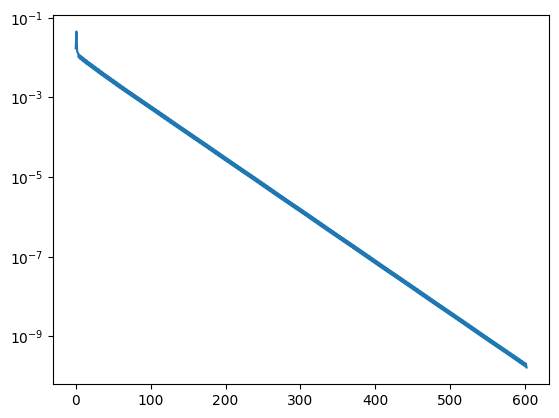

In [14]:
plt.yscale('log')
plt.plot(errhist);

Jacobi and Gauss Seidel Preconditioners
===
For a given residual $r$, the Jacobi preconditioner computes

$$
w = D^{-1} r
$$

with $D = \text{diag} A$. If $r_i$ is the $i^{th}$ component of the residual, the correction step of the $i^{th}$ variable is $w_i = A_{ii}^{-1} r_i$. All these correction steps are computed for the same residual.

In contrast, the Gauss-Seidel iteration updates the $i^{th}$ variable from the residual computed from all up to date variables:

for $i = 1, \ldots, n$: <br>
$\qquad \hat x_i = x_i + A_{ii}^{-1} \big( b_i - \sum_{j=1}^{i-1} A_{ij} \hat x_j - \sum_{j=i}^n A_{ij} x_j \big)$

The method depends on the enumeration of variables. E.g, one could loop backwards, and thus obtains the so-called backward Gauss-Seidel iteration.

There holds for every $1 \leq i \leq n$:
$$
\sum_{j=1}^i A_{ij} \hat x_j = b_i - \sum_{j=i+1}^n A_{ij} x_j
$$

If we split the matrix 

$$
A = L + D + R
$$

with a strictly lower triangular matrix $L$, a diagonal matrix $D$, and a strictly upper diagonal matrix $R$ we can write

$$
(L+D) \hat x = b - R x
$$

or

$$
(L+D) \hat x = (L+D) x + b - A x
$$

or

$$
\hat x = x + (L+D)^{-1} (b - A x)
$$

This means we can interpret the Gauss-Seidel iteration as a preconditioned Richardson iteration, with preconditioner $C = L+D$. In general, this is not a symmetric preconditioner.

If we run the backward Gauss-Seidel iteration, the preconditioner becomes $C = D + R$. Now, we combine one step forward, with one step backward Gauss-Seidel:

\begin{eqnarray*}
\tilde x & = & x + (L+D)^{-1} (b - A x) \\
\hat x & = & \tilde x + (D+R)^{-1} (b - A \tilde x)
\end{eqnarray*}


we can write

\begin{eqnarray*}
\hat x & = & (D+R)^{-1} (b - L \tilde x) \\
& = & (D+R)^{-1} \big(b - L (L+D)^{-1} (b - R x) \big) \\
& = & (D+R)^{-1} \big( (L+D)(L+D)^{-1} b - L (L+D)^{-1} b \big) + \ldots x \\
& = & (D+R)^{-1} D (L+D)^{-1} b + \ldots x \\
& = & x + (D+R)^{-1} D (L+D)^{-1} (b - A x)
\end{eqnarray*}

and observe that the combined forward-backward Gauss-Seidel iteration is a Richardson method with preconditioner 

$$
C_{FBGS}^{-1} = (D+R)^{-1} D (L+D)^{-1}.
$$

If $A$ is symmetric, then $(L+D)^T = D+R$, and $C_{FBGS}$ is symmetric as well. If $A$ is SPD, then we obtain 

$$
x^T C_{FBGS} x \geq x^T A x  \qquad \forall \, x
$$

i.e. the spectral constant $\gamma_2 = 1$, and choosing a damping parameter $\alpha = 1$ is guaranteed to converge.

We prove this by calculation:
\begin{eqnarray*}
C_{FBGS} & = & (L+D) D^{-1} (D+R) \\
& = & L + D + R + L D^{-1} R \\
& = & A + L D^{-1} R
\end{eqnarray*}

Since $x^T L D^{-1} R x = (R x)^T D^{-1} (R x) = \| R x \|_{D^{-1}}^2 \geq 0$ we have proven that

$$
C_{FBGS} \geq A
$$

The error propagation matrix of the FB - GS is

$$
M_{FBGS} = \underbrace{(I - (D+R)^{-1} A)}_{M_{BGS}} \underbrace{ ( I - (D+L)^{-1} A) }_{M_{FBS}},
$$

and has norm $\| M_{FBGS} \|_A < 1$. The error propagation matrices
of the forward and backward GS are $A$-adjoint to each other:

$$
\left< M_{FGS} x, y \right>_A = \left< x, M_{BGS} y \right>_A
$$

Thus, a single forward (or single backward Gauss-Seidel) step is also convergenct:

$$
\left< M_{FGS} x, M_{FGS} x \right>_A = \left< M_{BGS} M_{FGS} x, x \right>_A \leq \| M_{FBGS} \|_A \| x \|_A^2
$$
